# 🏆 Torneo de Modelos en Cascada: Buñuelos La Floresta

Este notebook implementa una estrategia de optimización en cascada con seguimiento de **Modelo Candidato**:
1. **Calibración Técnica (Run 01):** Determina la mejor combinación de diferenciación y transformación.
2. **Selección de Variables (Runs 02-06):** Hereda la técnica ganadora y busca el mejor set de variables exógenas.
3. **Optimización por Eras (Run Final):** Aplica pesos temporales al campeón de variables.

---

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import os
import warnings
from datetime import datetime
import json
import re

from skforecast.direct import ForecasterDirect
from skforecast.recursive import ForecasterEquivalentDate
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster, TimeSeriesFold
from skforecast.preprocessing import RollingFeatures

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")

## ⚙️ 1. Configuración de Herramientas y Datos

In [55]:
with open('../config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

data_path = os.path.join('..', config['paths']['processed_data'], config['feature_engineering']['output']['filename'])
df = pd.read_parquet(data_path)
df.index = pd.to_datetime(df.index)
df = df.asfreq('MS')

figures_path = os.path.join('..', config['paths']['figures'], 'experiments')
os.makedirs(figures_path, exist_ok=True)

# Las variables de calendario ya vienen integradas en el parquet procesado (Fase 4)

test_months = config['eda']['splitting']['test_months']
val_months = config['eda']['splitting']['validation_months']
initial_train_size = len(df) - (test_months + val_months)
rs = config['forecasting']['random_state']
gap = config['forecasting']['gap']

model_map = {
    'LightGBM': lambda rs: LGBMRegressor(random_state=rs, verbose=-1, importance_type='gain'),
    'RandomForest': lambda rs: RandomForestRegressor(random_state=rs),
    'Ridge': lambda rs: Ridge(random_state=rs),
    'xgb.XGBRegressor': lambda rs: XGBRegressor(random_state=rs, verbosity=0)
}

def get_weight_func(exp_cfg):
    if not exp_cfg.get('training_options', {}).get('use_weights', False): return None
    def weight_func(index):
        t_opts = exp_cfg['training_options']
        w_dist = t_opts['weight_distribution']
        e_defs = t_opts.get('event_definitions', {})
        weights = np.ones(len(index)) * w_dist.get('default', 1.0)
        idx_dt = pd.to_datetime(index)
        for era, d in e_defs.items():
            mask = (idx_dt >= pd.to_datetime(d['start_date'])) & (idx_dt <= pd.to_datetime(d['end_date']))
            weights[mask] = w_dist.get(era, w_dist.get('default', 1.0))
        return weights
    return weight_func

print(f"✅ {len(df)} meses cargados. Herramientas listas.")

✅ 86 meses cargados. Herramientas listas.


## 🍦 2. Punto de Referencia y Primer Candidato

In [56]:
forecaster_naive = ForecasterEquivalentDate(offset=12, n_offsets=1)
forecaster_naive.fit(y=df['unidades'].iloc[:-test_months])
mae_naive = mean_absolute_error(df['unidades'].iloc[-test_months:], forecaster_naive.predict(steps=test_months))

candidate_mae = mae_naive
candidate_name = "Seasonal Naive (Baseline)"
candidate_exp = "Baseline (Run 00)"
candidate_details = {
    "Origen": "Run 00 (Baseline)",
    "Modelo": "Seasonal Naive (Persistence)",
    "Lags": "12 meses (Estacionalidad Anual)",
    "Exógenas": "Ninguna",
    "Transformación": "Ninguna",
    "Diferenciación": "Ninguna",
    "Ventanas Rodantes": "Desactivadas",
    "Pesos (Eras)": "Desactivados"
}

print(f"📊 MAE Baseline: {mae_naive:,.0f} buñuelitos")
print(f"📌 Modelo Candidato Actual: {candidate_name}")

📊 MAE Baseline: 47,636 buñuelitos
📌 Modelo Candidato Actual: Seasonal Naive (Baseline)


## 🧪 3. Laboratorio Técnico (Run 01)
Determina si el candidato mejora con cambios técnicos (Diferenciación/Transformación).

In [57]:
run01 = [e for e in config['experiments'] if e['name'] == 'run01_endogenous'][0]
tech_results = []

# Extraemos configuración de ventanas rodantes para Run 01
wf_cfg_01 = run01['forecasting_parameters'].get('window_features', {})
rolling_features_01 = RollingFeatures(stats=wf_cfg_01['stats'], window_sizes=wf_cfg_01['window_sizes']) if wf_cfg_01.get('enabled') else None

for diff in [None, 1]:
    for trans in [None, 'yeo-johnson']:
        transformer = PowerTransformer(method='yeo-johnson') if trans else None
        cv_tuning = TimeSeriesFold(steps=6, gap=gap, initial_train_size=initial_train_size, differentiation=diff)
        cv_backtest = TimeSeriesFold(steps=6, gap=gap, initial_train_size=len(df)-test_months, differentiation=diff, refit=False)
        
        for m_name in run01['models_to_train']:
            forecaster = ForecasterDirect(
                estimator=model_map[m_name](rs), lags=12, steps=6+gap, 
                transformer_y=transformer, differentiation=diff,
                window_features=rolling_features_01
            )
            results_grid = grid_search_forecaster(
                forecaster=forecaster, y=df['unidades'].iloc[:-test_months], 
                param_grid=config['training_parameters']['hyperparameter_grids'][m_name], 
                lags_grid=run01['forecasting_parameters']['lags_grid'], 
                cv=cv_tuning, metric='mean_absolute_error', return_best=True, verbose=False
            )
            mae, _ = backtesting_forecaster(forecaster=forecaster, y=df['unidades'], cv=cv_backtest, metric='mean_absolute_error', verbose=False)
            
            if isinstance(mae, pd.DataFrame): mae_val = mae.iloc[0, 0]
            elif isinstance(mae, pd.Series): mae_val = mae.iloc[0]
            else: mae_val = float(mae)
            
            tech_results.append({
                'diff': diff, 'trans': trans, 'model': m_name, 'MAE': mae_val, 
                'lags': results_grid.iloc[0]['lags'], 'params': results_grid.iloc[0]['params'],
                'rolling': f"{wf_cfg_01.get('stats')} en {wf_cfg_01.get('window_sizes')}" if rolling_features_01 else "Desactivadas"
            })

df_tech = pd.DataFrame(tech_results).sort_values('MAE')
best_tech = df_tech.iloc[0]
inherited_diff = int(best_tech['diff']) if pd.notnull(best_tech['diff']) else None
inherited_trans = best_tech['trans']

improvement = (candidate_mae - best_tech['MAE']) / candidate_mae
print(f"🏆 Mejor Técnica: Diff={inherited_diff}, Trans={inherited_trans} (MAE: {best_tech['MAE']:,.0f})")
print(f"📈 Mejora técnica vs {candidate_name}: {improvement:.2%}")

if best_tech['MAE'] < candidate_mae:
    candidate_mae = best_tech['MAE']
    candidate_name = f"{best_tech['model']} (Técnico)"
    candidate_exp = "run01_endogenous"
    candidate_details = {
        "Origen": f"run01_endogenous (Optimización Técnica)",
        "Modelo": best_tech['model'],
        "Lags": best_tech['lags'],
        "Exógenas": "Endógenas pura",
        "Transformación": str(best_tech['trans']),
        "Diferenciación": str(best_tech['diff']),
        "Ventanas Rodantes": best_tech['rolling'],
        "Pesos (Eras)": "Desactivados",
        "Hiperparámetros": best_tech['params']
    }
    print(f"✨ NUEVO MODELO CANDIDATO: {candidate_name}")
else:
    print(f"ℹ️ Se mantiene el candidato anterior: {candidate_name}")

lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 64}
  Backtesting metric: 68557.61110579102


lags grid: 100%|██████████| 1/1 [00:12<00:00, 12.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
  Backtesting metric: 45428.340000000004


lags grid: 100%|██████████| 1/1 [00:00<00:00, 24.34it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 100.0}
  Backtesting metric: 22801.113146254156


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 48167.669596354164


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 64}
  Backtesting metric: 80018.20061085418


lags grid: 100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
  Backtesting metric: 46429.13517219832


lags grid: 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.1}
  Backtesting metric: 21878.215802267194


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
  Backtesting metric: 44689.75158121919


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 64}
  Backtesting metric: 29541.49181044512


lags grid: 100%|██████████| 1/1 [00:27<00:00, 27.95s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 500}
  Backtesting metric: 23662.817


lags grid: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 100.0}
  Backtesting metric: 21814.4166914917


lags grid: 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 20368.17508951823


lags grid: 100%|██████████| 1/1 [00:11<00:00, 11.96s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31}
  Backtesting metric: 20138.576215109402


lags grid: 100%|██████████| 1/1 [00:10<00:00, 10.05s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
  Backtesting metric: 33258.25823589722


lags grid: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.1}
  Backtesting metric: 16371.843013404869


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
  Backtesting metric: 25147.47738843088


100%|██████████| 2/2 [00:00<00:00, 242.07it/s]

🏆 Mejor Técnica: Diff=1, Trans=None (MAE: 35,672)
📈 Mejora técnica vs Seasonal Naive (Baseline): 25.11%
✨ NUEVO MODELO CANDIDATO: xgb.XGBRegressor (Técnico)


## 📡 4. Torneo de Variables Exógenas (Runs 02-06)
Evaluamos si añadir información externa mejora al candidato técnico.

In [58]:
var_leaderboard = []
transformer_inherited = PowerTransformer(method='yeo-johnson') if inherited_trans else None

for exp in config['experiments']:
    if exp['name'] == 'run01_endogenous' or exp['name'] == 'run_final' or not exp.get('enabled'): continue
    
    exog_cols = [c for c in df.columns if c != 'unidades'] if exp['exogenous_features']['features_to_use'] == 'all' else exp['exogenous_features']['features_to_use']
    cv_tuning = TimeSeriesFold(steps=6, gap=gap, initial_train_size=initial_train_size, differentiation=inherited_diff)
    cv_backtest = TimeSeriesFold(steps=6, gap=gap, initial_train_size=len(df)-test_months, differentiation=inherited_diff, refit=False)
    
    # Ventanas Rodantes si están habilitadas en el experimento
    wf_cfg = exp['forecasting_parameters'].get('window_features', {})
    rolling_features = RollingFeatures(stats=wf_cfg['stats'], window_sizes=wf_cfg['window_sizes']) if wf_cfg.get('enabled') else None

    for m_name in exp['models_to_train']:
        forecaster = ForecasterDirect(
            estimator=model_map[m_name](rs), lags=12, steps=6+gap, 
            transformer_y=transformer_inherited, differentiation=inherited_diff,
            window_features=rolling_features
        )
        results_grid = grid_search_forecaster(
            forecaster=forecaster, y=df['unidades'].iloc[:-test_months], exog=df[exog_cols].iloc[:-test_months], 
            param_grid=config['training_parameters']['hyperparameter_grids'][m_name], 
            lags_grid=exp['forecasting_parameters']['lags_grid'], 
            cv=cv_tuning, metric='mean_absolute_error', return_best=True, verbose=False
        )
        mae, _ = backtesting_forecaster(forecaster=forecaster, y=df['unidades'], exog=df[exog_cols], cv=cv_backtest, metric='mean_absolute_error', verbose=False)
        
        if isinstance(mae, pd.DataFrame): mae_val = mae.iloc[0, 0]
        elif isinstance(mae, pd.Series): mae_val = mae.iloc[0]
        else: mae_val = float(mae)
            
        var_leaderboard.append({
            'exp': exp['name'], 'model': m_name, 'MAE': mae_val, 'exog': exog_cols, 
            'lags': results_grid.iloc[0]['lags'], 'params': results_grid.iloc[0]['params'],
            'rolling': f"{wf_cfg.get('stats')} en {wf_cfg.get('window_sizes')}" if rolling_features else "Desactivadas"
        })

df_vars = pd.DataFrame(var_leaderboard).sort_values('MAE')
best_var = df_vars.iloc[0]
champion_var_list = best_var['exog'] 

improvement = (candidate_mae - best_var['MAE']) / candidate_mae
print(f"🏅 Mejor Set de Variables: {best_var['exp']} con {best_var['model']} (MAE: {best_var['MAE']:,.0f})")
print(f"📈 Mejora por variables vs {candidate_name}: {improvement:.2%}")

if best_var['MAE'] < candidate_mae:
    candidate_mae = best_var['MAE']
    candidate_name = f"{best_var['model']} + Set {best_var['exp']}"
    candidate_exp = best_var['exp']
    candidate_details = {
        "Origen": f"{best_var['exp']} (Torneo de Variables)",
        "Modelo": best_var['model'],
        "Lags": best_var['lags'],
        "Exógenas": f"{len(best_var['exog'])} variables (Set {best_var['exp']})",
        "Variables Listado": ", ".join(best_var['exog']),
        "Transformación": str(inherited_trans),
        "Diferenciación": str(inherited_diff),
        "Ventanas Rodantes": best_var['rolling'],
        "Pesos (Eras)": "Desactivados",
        "Hiperparámetros": best_var['params']
    }
    print(f"✨ NUEVO MODELO CANDIDATO: {candidate_name}")
else:
    print(f"ℹ️ Se mantiene el candidato anterior: {candidate_name}")

lags grid: 100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 64}
  Backtesting metric: 26621.992642123223


lags grid: 100%|██████████| 1/1 [00:07<00:00,  7.22s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
  Backtesting metric: 21454.737833333336


lags grid: 100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 100.0}
  Backtesting metric: 21415.213698791344


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 15627.113321940104


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 64}
  Backtesting metric: 27128.089453929428


lags grid: 100%|██████████| 1/1 [00:07<00:00,  7.73s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
  Backtesting metric: 20296.499270833334


lags grid: 100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 1.0}
  Backtesting metric: 19906.6216342073


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 18075.58025105794


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 64}
  Backtesting metric: 27128.089453929428


lags grid: 100%|██████████| 1/1 [00:07<00:00,  7.86s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
  Backtesting metric: 19766.94


lags grid: 100%|██████████| 1/1 [00:00<00:00, 18.90it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.1}
  Backtesting metric: 16760.752514710108


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 18117.908813476562


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 64}
  Backtesting metric: 27789.101093781937


lags grid: 100%|██████████| 1/1 [00:08<00:00,  8.30s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
  Backtesting metric: 21038.778333333332


lags grid: 100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 33729.54239283514


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 18454.911763509113


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 64}
  Backtesting metric: 27836.82122033615


lags grid: 100%|██████████| 1/1 [00:08<00:00,  8.52s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
  Backtesting metric: 21097.10916666667


lags grid: 100%|██████████| 1/1 [00:00<00:00, 17.25it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 10.0}
  Backtesting metric: 25215.661275823804


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 18139.559987386066


100%|██████████| 2/2 [00:00<00:00, 182.04it/s]

🏅 Mejor Set de Variables: run06_master_integral con Ridge (MAE: 19,658)
📈 Mejora por variables vs xgb.XGBRegressor (Técnico): 44.89%
✨ NUEVO MODELO CANDIDATO: Ridge + Set run06_master_integral


## 🏆 5. Gran Final: Optimización por Eras (Run Final)
Evaluamos si la ponderación temporal corona al Campeón Final.

In [59]:
exp_final = [e for e in config['experiments'] if e['name'] == 'run_final'][0]
exog_final = champion_var_list
w_func = get_weight_func(exp_final)

cv_tuning = TimeSeriesFold(steps=6, gap=gap, initial_train_size=initial_train_size, differentiation=inherited_diff)
cv_backtest = TimeSeriesFold(steps=6, gap=gap, initial_train_size=len(df)-test_months, differentiation=inherited_diff, refit=False)

final_results = []
for m_name in exp_final['models_to_train']:
    rolling_features = None
    wf_cfg = exp_final['forecasting_parameters'].get('window_features', {})
    if wf_cfg.get('enabled'):
        rolling_features = RollingFeatures(stats=wf_cfg['stats'], window_sizes=wf_cfg['window_sizes'])

    forecaster = ForecasterDirect(
        estimator=model_map[m_name](rs), lags=12, steps=6+gap, 
        transformer_y=transformer_inherited, differentiation=inherited_diff, 
        weight_func=w_func, window_features=rolling_features
    )
    results_grid = grid_search_forecaster(
        forecaster=forecaster, y=df['unidades'].iloc[:-test_months], exog=df[exog_final].iloc[:-test_months], 
        param_grid=config['training_parameters']['hyperparameter_grids'][m_name], 
        lags_grid=exp_final['forecasting_parameters']['lags_grid'], 
        cv=cv_tuning, metric='mean_absolute_error', return_best=True, verbose=False
    )
    mae, _ = backtesting_forecaster(forecaster=forecaster, y=df['unidades'], exog=df[exog_final], cv=cv_backtest, metric='mean_absolute_error', verbose=False)
    
    if isinstance(mae, pd.DataFrame): mae_val = mae.iloc[0, 0]
    elif isinstance(mae, pd.Series): mae_val = mae.iloc[0]
    else: mae_val = float(mae)
        
    final_results.append({
        'model': m_name, 'MAE': mae_val, 
        'lags': results_grid.iloc[0]['lags'], 'params': results_grid.iloc[0]['params'],
        'rolling': f"{wf_cfg.get('stats')} en {wf_cfg.get('window_sizes')}" if rolling_features else "Desactivadas"
    })

df_final = pd.DataFrame(final_results).sort_values('MAE')
best_final = df_final.iloc[0]

improvement = (candidate_mae - best_final['MAE']) / candidate_mae
print(f"🏁 Resultado con Ponderación (Eras): {best_final['model']} (MAE: {best_final['MAE']:,.0f})")
print(f"📈 Mejora por Eras vs {candidate_name}: {improvement:.2%}")

if best_final['MAE'] < candidate_mae:
    candidate_mae = best_final['MAE']
    candidate_name = f"{best_final['model']} + Eras (Final)"
    candidate_exp = "run_final"
    candidate_details = {
        "Origen": "run_final (Optimización por Eras)",
        "Modelo": best_final['model'],
        "Lags": best_final['lags'],
        "Exógenas": f"{len(exog_final)} variables (Heredadas de {best_var['exp']})",
        "Variables Listado": ", ".join(exog_final),
        "Transformación": str(inherited_trans),
        "Diferenciación": str(inherited_diff),
        "Ventanas Rodantes": best_final['rolling'],
        "Pesos (Eras)": "✅ Activados",
        "Hiperparámetros": best_final['params']
    }
    print("✨ NUEVO MODELO CANDIDATO: La ponderación por eras ha mejorado el resultado.")
else:
    print(f"ℹ️ Se mantiene el candidato anterior: {candidate_name}")

print("\n" + "="*60)
print("🏆 INFORME TÉCNICO DEL MODELO CAMPEÓN FINAL")
print("="*60)
for key, value in candidate_details.items():
    if key == "Variables Listado":
        print(f"- {key}:")
        print(f"  {value}")
    else:
        print(f"- {key}: {value}")
print("-"*60)
print(f"📊 MAE FINAL LOGRADO: {candidate_mae:,.0f} buñuelitos")
print(f"🚀 MEJORA CONSOLIDADA VS BASELINE: {((mae_naive - candidate_mae)/mae_naive):.2%}")
print("="*60)

# --- Exportar informe a JSON ---
import json
from datetime import datetime

# 1. Preparar la estructura del JSON
report_data = {
    "informe_técnico": {
        "origen": candidate_details.get("Origen"),
        "modelo": candidate_details.get("Modelo"),
        "lags": str(candidate_details.get("Lags")),
        "exógenas_conteo": candidate_details.get("Exógenas"),
        "variables_listado": candidate_details.get("Variables Listado"),
        "transformación": candidate_details.get("Transformación"),
        "diferenciación": candidate_details.get("Diferenciación"),
        "ventanas_rodantes": candidate_details.get("Ventanas Rodantes"),
        "pesos_eras": candidate_details.get("Pesos (Eras)"),
        "hiperparámetros": candidate_details.get("Hiperparámetros")
    },
    "métricas_finales": {
        "mae_final": f"{candidate_mae:,.0f} buñuelitos",
        "mejora_vs_baseline": f"{((mae_naive - candidate_mae)/mae_naive):.2%}"
    },
    "metadata": {
        "fecha_ejecución": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "notebook_origen": "05_run_experiments.ipynb"
    }
}

# 2. Definir ruta y nombre del archivo
metrics_path = os.path.join('..', config['paths'].get('metrics', 'outputs/metrics/'))
os.makedirs(metrics_path, exist_ok=True)

timestamp_json = datetime.now().strftime('%Y%m%d_%H%M%S')
json_filename = f"champion_model_{timestamp_json}.json"
json_full_path = os.path.join(metrics_path, json_filename)

# 3. Guardar archivo
with open(json_full_path, 'w', encoding='utf-8') as f:
    json.dump(report_data, f, indent=4, ensure_ascii=False)

print(f"\n💾 Informe técnico exportado a: {json_filename}")


lags grid: 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 64}
  Backtesting metric: 25716.723592157705


lags grid: 100%|██████████| 1/1 [00:08<00:00,  8.59s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
  Backtesting metric: 20590.183333333334


lags grid: 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 1.0}
  Backtesting metric: 20167.593877409632


lags grid: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 16637.08076985677


100%|██████████| 2/2 [00:00<00:00, 193.81it/s]

🏁 Resultado con Ponderación (Eras): xgb.XGBRegressor (MAE: 28,302)
📈 Mejora por Eras vs Ridge + Set run06_master_integral: -43.97%
ℹ️ Se mantiene el candidato anterior: Ridge + Set run06_master_integral

🏆 INFORME TÉCNICO DEL MODELO CAMPEÓN FINAL
- Origen: run06_master_integral (Torneo de Variables)
- Modelo: Ridge
- Lags: [1 2 3]
- Exógenas: 29 variables (Set run06_master_integral)
- Variables Listado:
  es_atipico, festivos_conteo, fines_semana_conteo, es_semana_santa, conteo_novenas, es_puente_festivo, efecto_quincena, es_feria_flores, mes, trimestre, anio, semestre, mes_sin, mes_cos, trimestre_sin, trimestre_cos, flag_covid, flag_retail, maduracion_contrato, intensidad_comercial, crecimiento_yoy, growth_momentum_3m, growth_momentum_6m, ipc_mensual, trm_promedio, tasa_desempleo, costo_insumos_index, mes_de_prima, ipc_alimentos_mensual
- Transformación: None
- Diferenciación: 1
- Ventanas Rodantes: ['mean', 'mean', 'mean', 'std', 'std', 'std', 'max', 'max', 'max'] en [3, 6, 12, 3, 6,

## 🔍 6. Diagnóstico del Modelo Campeón (Interpretabilidad)
Abrimos la "caja negra" para entender qué está viendo el modelo.

In [60]:
print(f"🔨 Recreando el Forecaster Campeón ({candidate_details['Modelo']})...")

# 1. Recrear configuración técnica
final_diff = int(float(candidate_details['Diferenciación'])) if candidate_details['Diferenciación'] != "None" else None
final_trans_obj = PowerTransformer(method='yeo-johnson') if candidate_details['Transformación'] == 'yeo-johnson' else None
final_exog = champion_var_list if "variable" in candidate_details['Exógenas'].lower() else None

final_roll = None
if "en" in candidate_details['Ventanas Rodantes']:
    import re
    # Extraer arrays de la cadena informativa
    all_arrays = re.findall(r'\[.*?\]', candidate_details['Ventanas Rodantes'])
    stats = eval(all_arrays[0])
    sizes = eval(all_arrays[1])
    final_roll = RollingFeatures(stats=stats, window_sizes=sizes)

w_func_final = get_weight_func(exp_final) if "Activados" in candidate_details['Pesos (Eras)'] else None

# 2. Instanciar Estimador y Aplicar Params
estimator = model_map[candidate_details['Modelo']](rs)
estimator.set_params(**candidate_details['Hiperparámetros'])

# 3. Instanciar Forecaster
champion_forecaster = ForecasterDirect(
    estimator=estimator, 
    lags=candidate_details['Lags'], 
    steps=6+gap, 
    transformer_y=final_trans_obj, 
    differentiation=final_diff,
    window_features=final_roll,
    weight_func=w_func_final
)

print("✅ Forecaster reconstruido. Entrenando para diagnóstico...")

# 4. Entrenar con todos los datos menos el test para el diagnóstico
if final_exog is not None:
    champion_forecaster.fit(y=df['unidades'].iloc[:-test_months], exog=df[final_exog].iloc[:-test_months])
else:
    champion_forecaster.fit(y=df['unidades'].iloc[:-test_months])

🔨 Recreando el Forecaster Campeón (Ridge)...
✅ Forecaster reconstruido. Entrenando para diagnóstico...


### 📉 Comparativa Visual: Real vs Predicción
¿Qué tan cerca estuvimos en el periodo de prueba?

100%|██████████| 2/2 [00:00<00:00, 485.42it/s]


📊 TABLA DE COMPARATIVO Y DESVIACIÓN


,Real,Predicción,Error Absoluto,Desviación (%)
2025-02-01 00:00:00,"95,338","94,483",855,0.90%
2025-03-01 00:00:00,"114,850","131,671","16,821",14.65%
2025-04-01 00:00:00,"125,573","132,646","7,073",5.63%
2025-05-01 00:00:00,"122,285","161,525","39,240",32.09%
2025-06-01 00:00:00,"189,964","242,391","52,427",27.60%
2025-07-01 00:00:00,"200,527","168,553","31,974",15.94%
2025-08-01 00:00:00,"167,301","171,075","3,774",2.26%
2025-09-01 00:00:00,"138,805","139,772",967,0.70%
2025-10-01 00:00:00,"148,504","142,981","5,523",3.72%
2025-11-01 00:00:00,"156,305","196,224","39,919",25.54%


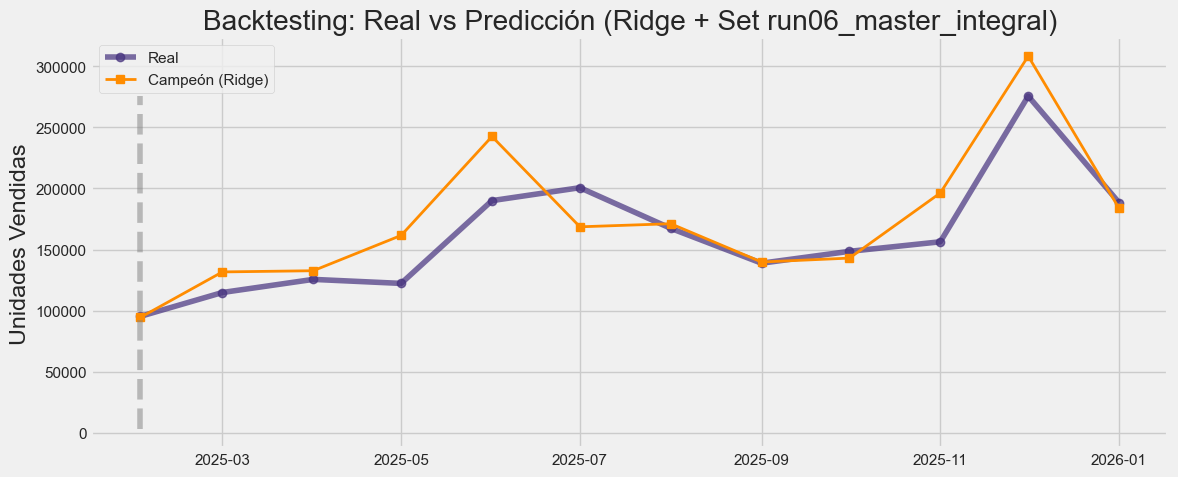

In [61]:
cv_diag = TimeSeriesFold(steps=6, gap=gap, initial_train_size=len(df)-test_months, differentiation=final_diff, refit=False)

if final_exog is not None:
    _, predictions = backtesting_forecaster(forecaster=champion_forecaster, y=df['unidades'], exog=df[final_exog], cv=cv_diag, metric='mean_absolute_error', verbose=False)
else:
    _, predictions = backtesting_forecaster(forecaster=champion_forecaster, y=df['unidades'], cv=cv_diag, metric='mean_absolute_error', verbose=False)

# Crear tabla de comparación
comparison_df = pd.DataFrame({
    'Real': df['unidades'].iloc[-test_months:],
    'Predicción': predictions['pred']
})
comparison_df['Error Absoluto'] = (comparison_df['Real'] - comparison_df['Predicción']).abs()
comparison_df['Desviación (%)'] = (comparison_df['Error Absoluto'] / comparison_df['Real']) * 100

print("\n📊 TABLA DE COMPARATIVO Y DESVIACIÓN")
display(comparison_df.style.format({
    'Real': '{:,.0f}',
    'Predicción': '{:,.0f}',
    'Error Absoluto': '{:,.0f}',
    'Desviación (%)': '{:.2f}%'
}).background_gradient(subset=['Desviación (%)'], cmap='YlOrRd'))

plt.figure(figsize=(12, 5))
plt.plot(df.index[-test_months:], df['unidades'].iloc[-test_months:], label='Real', marker='o', alpha=0.7)
plt.plot(predictions.index, predictions['pred'], label=f"Campeón ({candidate_details['Modelo']})", marker='s', color='darkorange', linewidth=2)
plt.vlines(df.index[-test_months], df['unidades'].min(), df['unidades'].max(), linestyles='dashed', colors='gray', alpha=0.5)
plt.title(f"Backtesting: Real vs Predicción ({candidate_name})")
plt.ylabel("Unidades Vendidas")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'backtesting_real_vs_pred.png'), bbox_inches='tight')
plt.show()

## 🔬 Diagnóstico Avanzado del Modelo Campeón

En esta sección profundizamos en el comportamiento del modelo **Ridge** seleccionado. Analizamos no solo qué variables impactan más, sino también la estructura de los errores para garantizar que el modelo sea robusto y no tenga sesgos temporales.

🔍 ANALIZANDO IMPORTANCIA DE CARACTERÍSTICAS (Ridge)


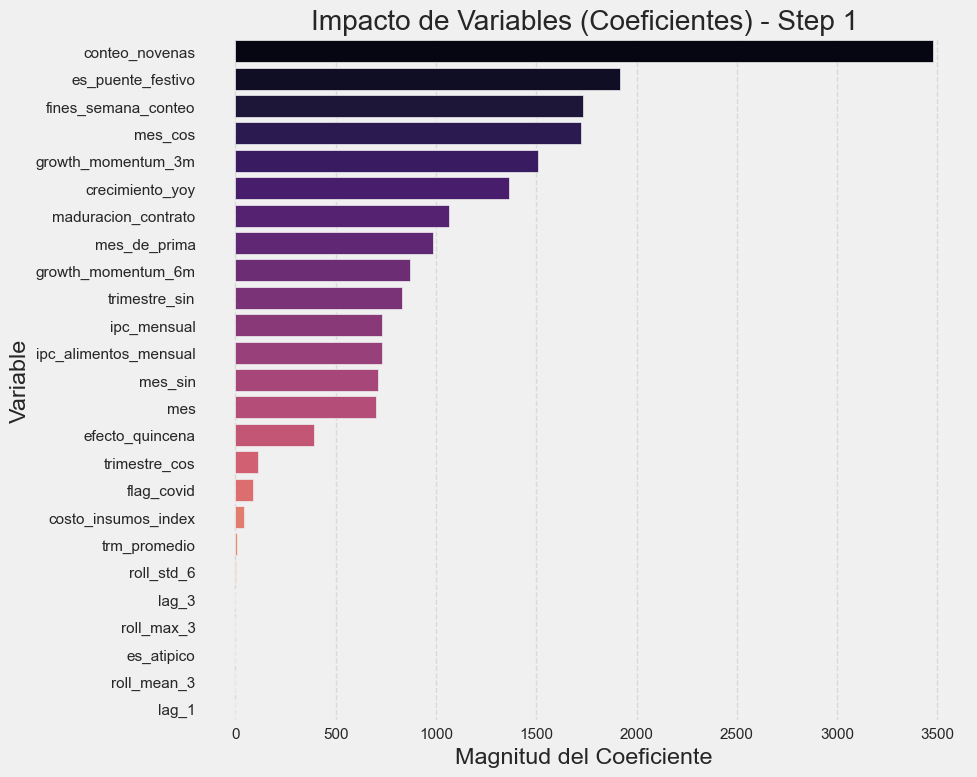

✅ Importancia visualizada correctamente.

📋 TABLA DE MAGNITUD DE COEFICIENTES (Top 25)


,feature,importance
16,conteo_novenas,3478.3699
17,es_puente_festivo,1916.0952
14,fines_semana_conteo,1731.7318
25,mes_cos,1724.8074
33,growth_momentum_3m,1507.7321
32,crecimiento_yoy,1362.1796
30,maduracion_contrato,1065.5375
39,mes_de_prima,986.2923
34,growth_momentum_6m,871.8628
26,trimestre_sin,830.5488


In [62]:
print(f"🔍 ANALIZANDO IMPORTANCIA DE CARACTERÍSTICAS ({candidate_details['Modelo']})")

try:
    # skforecast Direct devuelve importancia para cada step. Analizamos el step 1 como referencia general.
    importance = champion_forecaster.get_feature_importances(step=1)
    importance = importance.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importance.head(25), palette='magma')
    plt.title(f"Impacto de Variables (Coeficientes) - Step 1")
    plt.xlabel("Magnitud del Coeficiente")
    plt.ylabel("Variable")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(figures_path, 'diagnostic_feature_importance.png'), bbox_inches='tight')
    plt.show()
    
    print("✅ Importancia visualizada correctamente.")

    print("\n📋 TABLA DE MAGNITUD DE COEFICIENTES (Top 25)")
    display(importance.head(25).style.background_gradient(cmap='viridis', subset=['importance']).format({'importance': '{:.4f}'}))

except Exception as e:
    print(f"⚠️ No se pudo extraer la importancia: {str(e)}")

📊 ANÁLISIS DE RESIDUOS (ERRORES)


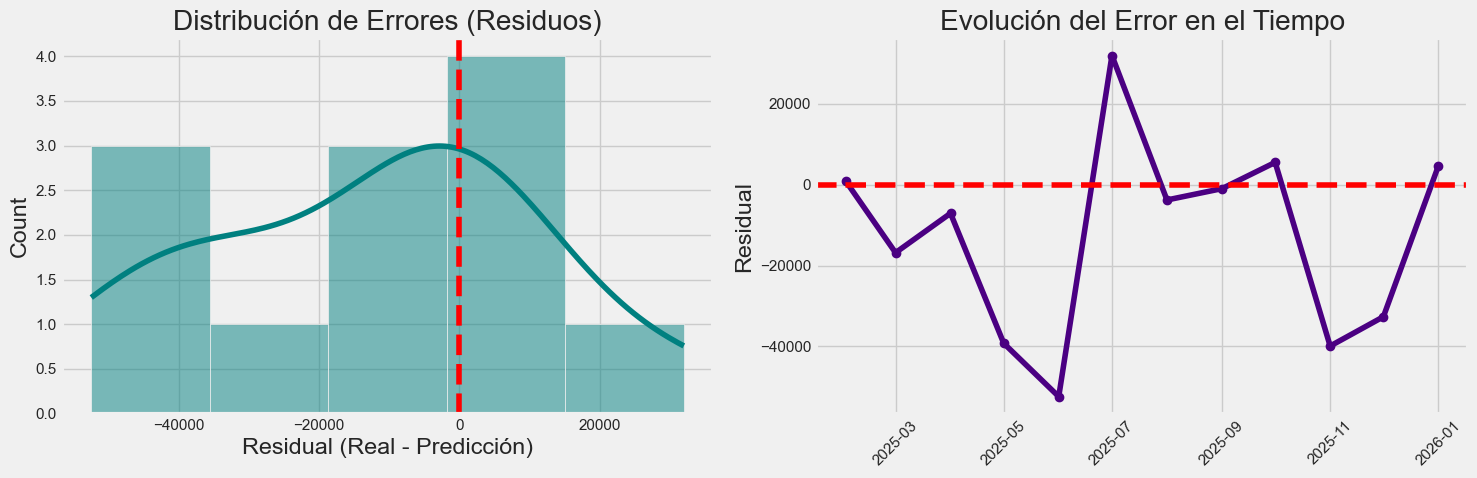

📋 ESTADÍSTICAS DETALLADAS DE RESIDUOS
----------------------------------------
🔹 Total de puntos analizados: 12
🔹 Under-forecasting (Se quedó corto): 4 puntos (33.3%)
🔹 Over-forecasting (Predijo de más): 8 puntos (66.7%)
🔹 Error Máximo (Subestimación): 31,974 buñuelos
🔹 Error Mínimo (Sobreestimación): -52,427 buñuelos
----------------------------------------
📈 Media del error: -12,491.16
📉 Mediana del error: -5,423.63
📏 Desviación estándar: 24,309.78
🎯 MAE del periodo: 19,658.41
🧪 RMSE del periodo: 26,414.91


In [63]:
print("📊 ANÁLISIS DE RESIDUOS (ERRORES)")

residuals = comparison_df['Real'] - comparison_df['Predicción']
n_obs = len(residuals)
under_forecast = residuals[residuals > 0]
over_forecast = residuals[residuals < 0]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# 1. Distribución de errores
sns.histplot(residuals, kde=True, ax=ax[0], color='teal')
ax[0].axvline(0, color='red', linestyle='--')
ax[0].set_title("Distribución de Errores (Residuos)")
ax[0].set_xlabel("Residual (Real - Predicción)")

# 2. Residuos en el tiempo
ax[1].plot(comparison_df.index, residuals, marker='o', linestyle='-', color='indigo')
ax[1].axhline(0, color='red', linestyle='--')
ax[1].set_title("Evolución del Error en el Tiempo")
ax[1].set_ylabel("Residual")
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'diagnostic_residuals.png'), bbox_inches='tight')
plt.show()

print("📋 ESTADÍSTICAS DETALLADAS DE RESIDUOS")
print("-" * 40)
print(f"🔹 Total de puntos analizados: {n_obs}")
print(f"🔹 Under-forecasting (Se quedó corto): {len(under_forecast)} puntos ({len(under_forecast)/n_obs:.1%})")
print(f"🔹 Over-forecasting (Predijo de más): {len(over_forecast)} puntos ({len(over_forecast)/n_obs:.1%})")
print(f"🔹 Error Máximo (Subestimación): {residuals.max():,.0f} buñuelos")
print(f"🔹 Error Mínimo (Sobreestimación): {residuals.min():,.0f} buñuelos")
print("-" * 40)
print(f"📈 Media del error: {residuals.mean():,.2f}")
print(f"📉 Mediana del error: {residuals.median():,.2f}")
print(f"📏 Desviación estándar: {residuals.std():,.2f}")
print(f"🎯 MAE del periodo: {residuals.abs().mean():,.2f}")
print(f"🧪 RMSE del periodo: {np.sqrt((residuals**2).mean()):,.2f}")

🤝 CORRELACIÓN REAL VS PREDICCIÓN


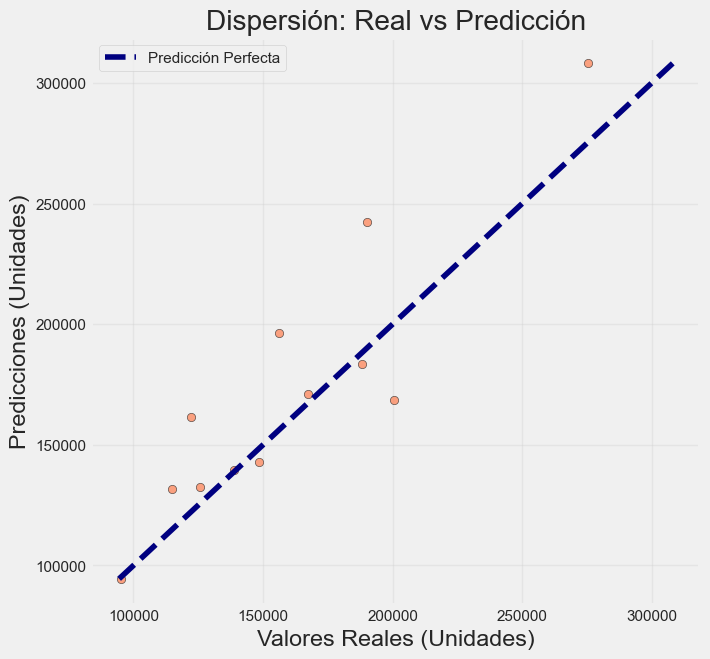

In [64]:
print("🤝 CORRELACIÓN REAL VS PREDICCIÓN")

plt.figure(figsize=(7, 7))
plt.scatter(comparison_df['Real'], comparison_df['Predicción'], alpha=0.7, edgecolors='k', color='coral')

# Línea de 45 grados
min_val = min(comparison_df['Real'].min(), comparison_df['Predicción'].min())
max_val = max(comparison_df['Real'].max(), comparison_df['Predicción'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='navy', linestyle='--', label='Predicción Perfecta')

plt.xlabel("Valores Reales (Unidades)")
plt.ylabel("Predicciones (Unidades)")
plt.title("Dispersión: Real vs Predicción")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(os.path.join(figures_path, 'diagnostic_dispersion.png'), bbox_inches='tight')
plt.show()

## 🦾 7. Re-entrenamiento Final (Data Completa)

Una vez validado el comportamiento y la interpretabilidad del modelo, procedemos al re-entrenamiento utilizando **el 100% de los datos disponibles**. Esto permite que el modelo aproveche los patrones más recientes encontrados en el periodo que anteriormente usamos para validación (test).

In [65]:
print(f"🚀 Iniciando re-entrenamiento final con toda la historia ({len(df)} meses)...")

# Re-entrenar el forecaster campeón con el dataset completo
if final_exog is not None:
    champion_forecaster.fit(y=df['unidades'], exog=df[final_exog])
else:
    champion_forecaster.fit(y=df['unidades'])

print("✅ Re-entrenamiento completado exitosamente.")
print(f"📌 El modelo ya conoce los datos hasta: {df.index[-1].strftime('%Y-%m-%d')}")

🚀 Iniciando re-entrenamiento final con toda la historia (86 meses)...
✅ Re-entrenamiento completado exitosamente.
📌 El modelo ya conoce los datos hasta: 2026-01-01


## 💾 Persistencia del Modelo

Finalmente, guardamos el modelo campeón para que pueda ser cargado en el pipeline de inferencia sin necesidad de re-entrenar.

In [66]:
import joblib
import os
import yaml
from datetime import datetime
import shutil

# Cargar configuración para obtener rutas
with open('../config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

models_path = config['paths'].get('models', 'outputs/models/')
full_output_dir = os.path.join('..', models_path)
os.makedirs(full_output_dir, exist_ok=True)

# 1. Generar nombre con marca de tiempo
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_base_name = 'champion_forecaster_ridge'
timestamped_filename = f"{model_base_name}_{timestamp}.joblib"
timestamped_path = os.path.join(full_output_dir, timestamped_filename)

# 2. Definir nombre del modelo final (copia fija)
final_model_filename = 'final_model.joblib'
final_model_path = os.path.join(full_output_dir, final_model_filename)

try:
    # Guardar archivo con timestamp (Versión Histórica)
    joblib.dump(champion_forecaster, timestamped_path)
    
    # Crear copia como 'final_model.joblib' (Versión Producción)
    shutil.copy2(timestamped_path, final_model_path)
    
    print(f"✅ ¡MODELOS GUARDADOS EXITOSAMENTE!")
    print(f"📌 Versión Histórica: {timestamped_filename}")
    print(f"🚀 Versión para Producción: {final_model_filename}")
    print(f"📍 Ubicación: {os.path.abspath(full_output_dir)}")
except Exception as e:
    print(f"❌ Error al guardar los modelos: {str(e)}")

✅ ¡MODELOS GUARDADOS EXITOSAMENTE!
📌 Versión Histórica: champion_forecaster_ridge_20260211_142530.joblib
🚀 Versión para Producción: final_model.joblib
📍 Ubicación: c:\Users\USUARIO\Documents\Forecaster\Buñuelos_LaFloresta\outputs\models


## 🚀 8. Generación del Pronóstico Real (Producción)

En esta sección final, generamos el pronóstico para los próximos 6 meses. Para las variables macroeconómicas, aplicamos la estrategia de **Proxy por Promedio** (usando los últimos dos meses conocidos) para llenar el horizonte futuro.

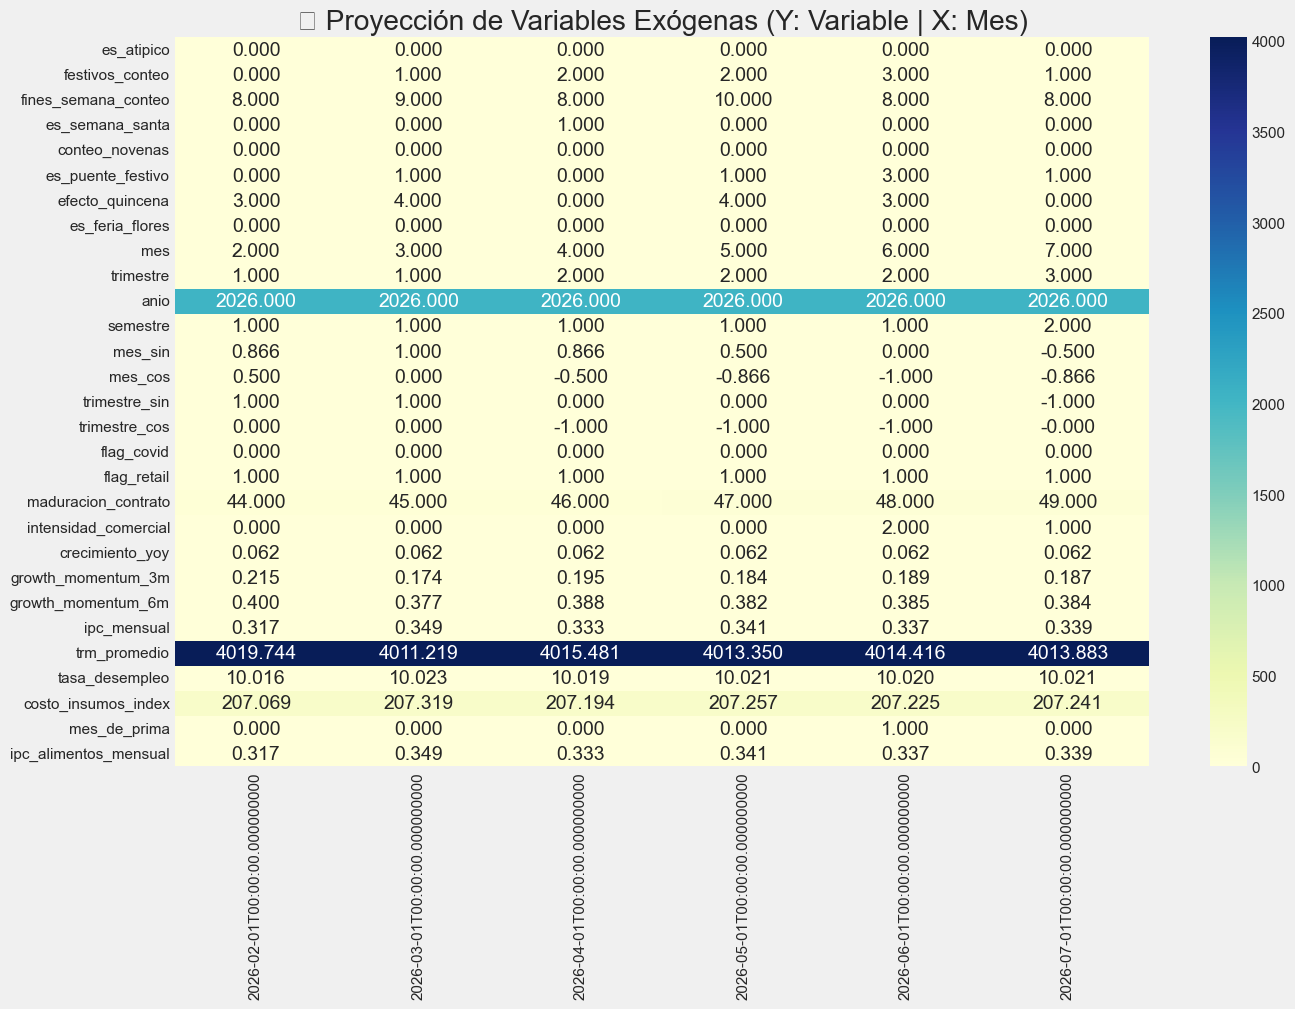

📊 Gráfica de exógenas guardada en: ..\outputs/figures/forecasts\exogenous_projection.png

🏆 PRONÓSTICO FINAL DE VENTAS


,Pronóstico (Unidades)
Mes,
2026-02,"187,887"
2026-03,"254,974"
2026-04,"239,900"
2026-05,"218,005"
2026-06,"308,955"
2026-07,"370,866"



💾 CSV exportado: final_forecast_20260211_142531.csv
💾 JSON actualizado: final_forecast_latest.json


In [67]:
import sys
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
from src.features import add_calendar_features, add_cyclic_features, add_intensity_features, add_structural_flags

# 1. Configuración de Rutas desde config.yaml
forecast_fig_dir = os.path.join('..', config['paths']['figures'], 'forecasts')
forecast_data_dir = os.path.join('..', config['paths']['forecasts'])
os.makedirs(forecast_fig_dir, exist_ok=True)
os.makedirs(forecast_data_dir, exist_ok=True)

# 2. Definir horizonte futuro (6 meses: X+1 a X+6)
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=6, freq='MS')
exog_future = pd.DataFrame(index=future_dates)

# Generar variables base
exog_future = add_calendar_features(exog_future)
exog_future = add_cyclic_features(exog_future)
exog_future = add_intensity_features(exog_future, config)
exog_future = add_structural_flags(exog_future, config)

# 3. Lógica de Proyección Recursiva (Económicas y Técnicas)
cols_recursive = [
    'ipc_mensual', 'trm_promedio', 'tasa_desempleo', 'costo_insumos_index', 
    'ipc_alimentos_mensual', 'crecimiento_yoy', 'growth_momentum_3m', 'growth_momentum_6m'
]
cols_to_process = [c for c in cols_recursive if c in df.columns]

for i, date in enumerate(exog_future.index):
    for col in cols_to_process:
        if i == 0:
            val = df[col].iloc[-2:].mean()
        elif i == 1:
            val = (df[col].iloc[-1] + exog_future.loc[exog_future.index[0], col]) / 2
        else:
            val = (exog_future.loc[exog_future.index[i-1], col] + exog_future.loc[exog_future.index[i-2], col]) / 2
        exog_future.loc[date, col] = val

# 4. Ajustes de Reglas de Negocio
exog_future['mes_de_prima'] = exog_future.index.month.isin([6, 12]).astype(int)
if 'es_atipico' not in exog_future.columns:
    exog_future['es_atipico'] = 0

# Asegurar orden y columnas del modelo campeón
if 'final_exog' in locals() and final_exog is not None:
    for col in final_exog:
        if col not in exog_future.columns:
            exog_future[col] = 0
    exog_future = exog_future[final_exog]
    
    # --- Visualización y Guardado de Exógenas ---
    exog_viz = exog_future.T
    plt.figure(figsize=(14, 9))
    sns.heatmap(exog_viz, annot=True, fmt=".3f", cmap='YlGnBu')
    plt.title("📈 Proyección de Variables Exógenas (Y: Variable | X: Mes)")
    
    plot_path = os.path.join(forecast_fig_dir, 'exogenous_projection.png')
    plt.savefig(plot_path, bbox_inches='tight')
    plt.show()
    print(f"📊 Gráfica de exógenas guardada en: {plot_path}")

    # 5. Ejecutar Predicción Final
    predictions = champion_forecaster.predict(steps=6, exog=exog_future)
else:
    predictions = champion_forecaster.predict(steps=6)

# 6. Formatear Resultados y Guardar
now = datetime.now()
timestamp_str = now.strftime('%Y%m%d_%H%M%S')

forecast_df = pd.DataFrame({
    'Mes': predictions.index.strftime('%Y-%m'),
    'Pronóstico (Unidades)': predictions.values.round(0).astype(int)
}).set_index('Mes')

# A. Guardar CSV (Con marca de tiempo)
csv_filename = f"final_forecast_{timestamp_str}.csv"
csv_path = os.path.join(forecast_data_dir, csv_filename)
forecast_df.to_csv(csv_path)

# B. Guardar JSON (Sobreescribir con timestamp interno)
json_filename = "final_forecast_latest.json"
json_path = os.path.join(forecast_data_dir, json_filename)
json_output = {
    "metadata": {
        "fecha_generacion": now.strftime('%Y-%m-%d %H:%M:%S'),
        "modelo_utilizado": candidate_details.get("Modelo", "Unknown"),
        "horizonte": "6 meses"
    },
    "pronostico": forecast_df.reset_index().to_dict(orient='records')
}
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(json_output, f, indent=4, ensure_ascii=False)

print("\n" + "="*45)
print("🏆 PRONÓSTICO FINAL DE VENTAS")
print("="*45)
display(forecast_df.style.format('{:,.0f}').background_gradient(cmap='Oranges'))
print(f"\n💾 CSV exportado: {csv_filename}")
print(f"💾 JSON actualizado: {json_filename}")

🛡️ Calculando Escenarios de Incertidumbre (Intervalo 95%)...


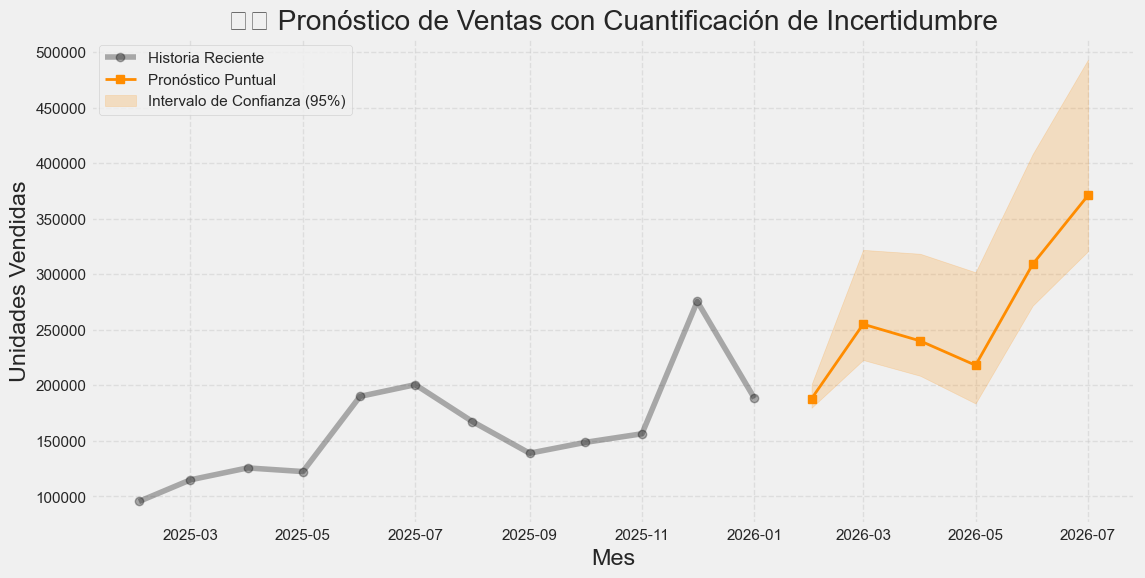


📊 ESCENARIOS OPERATIVOS PARA TOMA DE DECISIONES


,Pronóstico Puntual,Escenario Pesimista (2.5%),Escenario Optimista (97.5%)
2026-02,"187,887","179,694","200,740"
2026-03,"254,974","222,731","321,888"
2026-04,"239,900","208,486","318,369"
2026-05,"218,005","183,597","301,734"
2026-06,"308,955","271,633","408,115"
2026-07,"370,866","320,620","493,134"



✅ Análisis de incertidumbre completado. Archivos en: ..\outputs/forecasts/


In [72]:
# ==============================================================================
# 9. Cuantificación de la Incertidumbre (Intervalos de Predicción)
# ==============================================================================
print("🛡️ Calculando Escenarios de Incertidumbre (Intervalo 95%)...")

# 1. Re-entrenar con almacenamiento de residuos (Indispensable para intervalos)
# El error indica que el modelo actual no tiene los residuos necesarios almacenados.
if final_exog is not None:
    champion_forecaster.fit(
        y=df['unidades'], 
        exog=df[final_exog], 
        store_in_sample_residuals=True
    )
else:
    champion_forecaster.fit(
        y=df['unidades'], 
        store_in_sample_residuals=True
    )

# 2. Generar predicción con intervalos
# Según el traceback, skforecast espera un escalar decimal (0.95 para un 95% de confianza)
if 'final_exog' in locals() and final_exog is not None:
    predictions_interval = champion_forecaster.predict_interval(
        steps=6, 
        exog=exog_future, 
        interval=0.95,
        n_boot=250,
        random_state=rs
    )
else:
    predictions_interval = champion_forecaster.predict_interval(
        steps=6, 
        interval=0.95,
        n_boot=250,
        random_state=rs
    )

# 3. Formatear para visualización de negocio
interval_df = predictions_interval.copy()
interval_df.index = interval_df.index.strftime('%Y-%m')

# Mapeo de nombres para las columnas según el resultado de skforecast
mapping = {
    'pred': 'Pronóstico Puntual',
    'lower_bound': 'Escenario Pesimista (2.5%)',
    'upper_bound': 'Escenario Optimista (97.5%)'
}
interval_df = interval_df.rename(columns=mapping)

# 4. Visualización con Banda de Confianza
plt.figure(figsize=(12, 6))
# Contexto histórico reciente
plt.plot(df.index[-12:], df['unidades'].iloc[-12:], label='Historia Reciente', color='black', marker='o', alpha=0.3)
# Línea de tendencia proyectada
plt.plot(predictions_interval.index, predictions_interval['pred'], 
         label='Pronóstico Puntual', color='darkorange', marker='s', linewidth=2)

# Área de incertidumbre
plt.fill_between(
    predictions_interval.index,
    predictions_interval.iloc[:, 1], # Límite inferior detectado
    predictions_interval.iloc[:, 2], # Límite superior detectado
    color='darkorange', alpha=0.2, label='Intervalo de Confianza (95%)'
)

plt.title("🛡️ Pronóstico de Ventas con Cuantificación de Incertidumbre")
plt.ylabel("Unidades Vendidas")
plt.xlabel("Mes")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

# Guardar gráfica
uncertainty_plot_path = os.path.join(forecast_fig_dir, 'forecast_uncertainty_intervals.png')
plt.savefig(uncertainty_plot_path, bbox_inches='tight')
plt.show()

# 5. Mostrar Tabla de Escenarios
print("\n📊 ESCENARIOS OPERATIVOS PARA TOMA DE DECISIONES")
display(interval_df.style.format('{:,.0f}').background_gradient(cmap='YlOrRd', axis=1))

# 6. Exportar a JSON
json_interval_path = os.path.join(forecast_data_dir, 'final_forecast_intervals.json')
json_interval_output = {
    "metadata": {
        "fecha_generacion": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "confianza": "95%",
        "metodo": "Bootstrapping de residuos"
    },
    "escenarios": interval_df.reset_index().to_dict(orient='records')
}

with open(json_interval_path, 'w', encoding='utf-8') as f:
    json.dump(json_interval_output, f, indent=4, ensure_ascii=False)

print(f"\n✅ Análisis de incertidumbre completado. Archivos en: {forecast_data_dir}")

🔍 Analizando los principales impulsores del pronóstico...


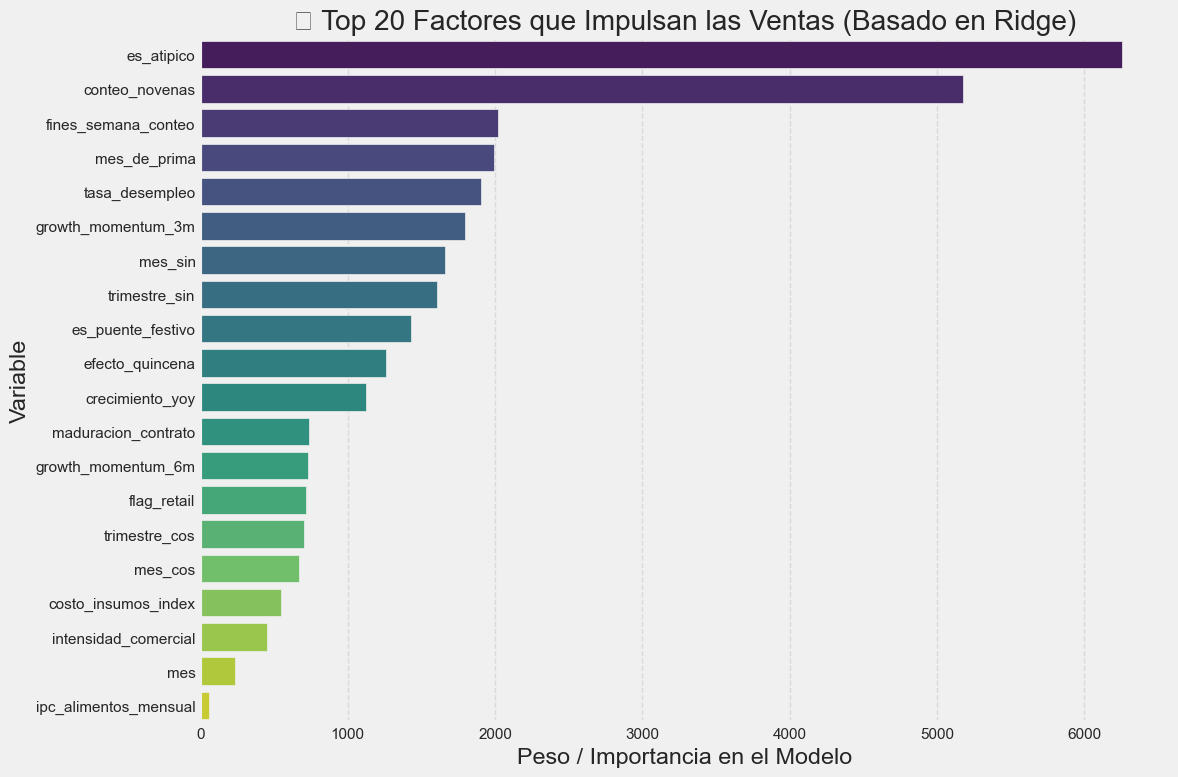


📋 CLASIFICACIÓN TÉCNICA DE VARIABLES (Impulsores de Demanda)


,feature,importance,Efecto
12,es_atipico,6255.356086,📈 Impulsa el aumento
16,conteo_novenas,5178.794773,📈 Impulsa el aumento
14,fines_semana_conteo,2020.555589,📈 Impulsa el aumento
39,mes_de_prima,1990.277443,📈 Impulsa el aumento
37,tasa_desempleo,1904.396229,📈 Impulsa el aumento
33,growth_momentum_3m,1798.303356,📈 Impulsa el aumento
24,mes_sin,1660.829829,📈 Impulsa el aumento
26,trimestre_sin,1605.472291,📈 Impulsa el aumento
17,es_puente_festivo,1431.735168,📈 Impulsa el aumento
18,efecto_quincena,1258.981533,📈 Impulsa el aumento



💡 INSIGHT CLAVE: La variable 'es_atipico' es el principal determinante del pronóstico.
Esto significa que el modelo está priorizando este factor para calcular las unidades futuras.


In [75]:
# ==============================================================================
# 11. ANÁLISIS DE INFLUENCIA (¿Por qué vendemos lo que vendemos?)
# ==============================================================================
print("🔍 Analizando los principales impulsores del pronóstico...")

try:
    # 1. Extraer importancia de características para el Step 1 (Próximo Mes)
    # skforecast permite ver qué variables influyeron más en la decisión del modelo
    importance = champion_forecaster.get_feature_importances(step=1)
    
    # 2. Diferenciar entre Coeficientes (Ridge) e Importancia (Bosques/Boosting)
    # Si el modelo es Ridge, 'importance' extrae los coeficientes normalizados
    importance = importance.sort_values('importance', ascending=False)

    # 3. Visualización de Impacto
    plt.figure(figsize=(12, 8))
    # Seleccionamos las Top 20 variables más influyentes
    top_n = 20
    sns.barplot(
        x='importance', 
        y='feature', 
        data=importance.head(top_n), 
        palette='viridis'
    )
    
    plt.title(f"🏆 Top {top_n} Factores que Impulsan las Ventas (Basado en {candidate_details.get('Modelo')})")
    plt.xlabel("Peso / Importancia en el Modelo")
    plt.ylabel("Variable")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Guardar gráfica de influencia
    influence_plot_path = os.path.join(forecast_fig_dir, 'feature_importance_forecast.png')
    plt.savefig(influence_plot_path, bbox_inches='tight')
    plt.show()

    # 4. Interpretación de Negocio (Tabla)
    print("\n📋 CLASIFICACIÓN TÉCNICA DE VARIABLES (Impulsores de Demanda)")
    
    # Añadimos una columna de interpretación simple
    def interpret_impact(val):
        if val > 0: return "📈 Impulsa el aumento"
        elif val < 0: return "📉 Reduce la demanda"
        else: return "⚪ Neutral"

    importance_display = importance.head(15).copy()
    if 'Ridge' in candidate_details.get('Modelo', ''):
        importance_display['Efecto'] = importance_display['importance'].apply(interpret_impact)
    
    display(importance_display.style.background_gradient(subset=['importance'], cmap='Greens'))

    # 5. Conclusión Verbal
    top_feature = importance.iloc[0]['feature']
    print(f"\n💡 INSIGHT CLAVE: La variable '{top_feature}' es el principal determinante del pronóstico.")
    print(f"Esto significa que el modelo está priorizando este factor para calcular las unidades futuras.")

except Exception as e:
    print(f"⚠️ No se pudo extraer la importancia detallada: {str(e)}")
    print("Esto puede ocurrir si el modelo base no soporta atributos de importancia o coeficientes directamente.")

In [76]:
# ==============================================================================
# 10. ENTREGABLE FINAL DE NEGOCIO (Consolidado Ejecutivo)
# ==============================================================================
print("📋 Generando Reporte Consolidado para Gerencia...")

# 1. Preparar Dataset del Entregable
business_deliverable = predictions_interval.copy()

# 2. Calcular Crecimiento Year-over-Year (YoY)
# Comparamos el pronóstico contra el mismo mes del año anterior disponible en df
yoy_growth = []
for date in business_deliverable.index:
    last_year_date = date - pd.DateOffset(years=1)
    if last_year_date in df.index:
        actual_last_year = df.loc[last_year_date, 'unidades']
        growth = (business_deliverable.loc[date, 'pred'] / actual_last_year) - 1
        yoy_growth.append(growth * 100)
    else:
        yoy_growth.append(np.nan)

business_deliverable['Crecimiento YoY (%)'] = yoy_growth

# 3. Generar Alertas de Calendario y Eventos
def generate_alerts(row_date):
    alerts = []
    exog_row = exog_future.loc[row_date]
    
    if exog_row.get('festivos_conteo', 0) >= 3: alerts.append("📌 Muchos Festivos")
    if exog_row.get('es_semana_santa', 0) == 1: alerts.append("🙏 Semana Santa")
    if exog_row.get('es_feria_flores', 0) == 1: alerts.append("🌸 Feria Flores")
    if exog_row.get('mes_de_prima', 0) == 1: alerts.append("💰 Mes de Prima")
    if exog_row.get('conteo_novenas', 0) > 0: alerts.append("🎄 Temporada Novenas")
    if exog_row.get('es_puente_festivo', 0) >= 2: alerts.append("🚗 Múltiples Puentes")
    
    return " | ".join(alerts) if alerts else "Operación Normal"

business_deliverable['Alertas y Eventos'] = [generate_alerts(d) for d in business_deliverable.index]

# 4. Formatear para Presentación
# Renombrar columnas para claridad
final_table = business_deliverable.rename(columns={
    'pred': 'Pronóstico Unidades',
    'lower_bound': 'Límite Inferior (Pesimista)',
    'upper_bound': 'Límite Superior (Optimista)'
})

# Formatear el índice para mostrar meses legibles
final_table.index = final_table.index.strftime('%B %Y')

# 5. Aplicar Estilo Visual Premium
def color_growth(val):
    color = 'green' if val > 0 else 'red'
    return f'color: {color}; font-weight: bold'

print("\n" + " ✨ REPORTE EJECUTIVO DE VENTAS: BUÑUELOS LA FLORESTA ✨ ".center(100, "="))
styled_table = final_table.style.format({
    'Pronóstico Unidades': '{:,.0f}',
    'Límite Inferior (Pesimista)': '{:,.0f}',
    'Límite Superior (Optimista)': '{:,.0f}',
    'Crecimiento YoY (%)': '{:+.2f}%'
}).applymap(color_growth, subset=['Crecimiento YoY (%)'])\
  .background_gradient(subset=['Pronóstico Unidades'], cmap='YlGn')\
  .set_properties(**{'text-align': 'center', 'font-size': '12pt'})\
  .set_table_styles([{'selector': 'th', 'props': [('background-color', '#2c3e50'), ('color', 'white'), ('font-family', 'Arial')]}])

display(styled_table)

# 6. Guardar Entregable Consolidado
business_report_path = os.path.join(forecast_data_dir, 'business_executive_report.csv')
final_table.to_csv(business_report_path)
print(f"\n💾 Reporte ejecutivo guardado en: {business_report_path}")

# Resumen Verbal
print("\n💡 OBSERVACIONES CLAVE:")
max_growth_month = final_table['Crecimiento YoY (%)'].idxmax()
print(f"- El mes con mayor crecimiento esperado es {max_growth_month}.")
print(f"- Se recomienda especial atención a los meses con alertas de 'Mes de Prima' o 'Festivos' para ajustar inventarios.")

📋 Generando Reporte Consolidado para Gerencia...

====================== ✨ REPORTE EJECUTIVO DE VENTAS: BUÑUELOS LA FLORESTA ✨ =======================


,Pronóstico Unidades,Límite Inferior (Pesimista),Límite Superior (Optimista),Crecimiento YoY (%),Alertas y Eventos
February 2026,"187,887","179,694","200,740",+97.07%,Operación Normal
March 2026,"254,974","222,731","321,888",+122.01%,Operación Normal
April 2026,"239,900","208,486","318,369",+91.04%,🙏 Semana Santa
May 2026,"218,005","183,597","301,734",+78.28%,Operación Normal
June 2026,"308,955","271,633","408,115",+62.64%,📌 Muchos Festivos | 💰 Mes de Prima | 🚗 Múltiples Puentes
July 2026,"370,866","320,620","493,134",+84.95%,Operación Normal



💾 Reporte ejecutivo guardado en: ..\outputs/forecasts/business_executive_report.csv

💡 OBSERVACIONES CLAVE:
- El mes con mayor crecimiento esperado es March 2026.
- Se recomienda especial atención a los meses con alertas de 'Mes de Prima' o 'Festivos' para ajustar inventarios.
